<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/FEM_tutorial_PDEconstrainedopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!/usr/bin/env python
# coding: utf-8
# In[91]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

In [42]:
meshsize= 100
h = 1./float(meshsize-1)
points = np.linspace(0,1,meshsize)

Some helper functions to evaluate tent functions and their derivatives.

In [43]:
def evalPhi_i(x):
    return tf.nn.relu(1.0-(tf.abs(tf.expand_dims(x,0)-tf.expand_dims(points,1)))/h)

def evalGradPhi_i(x):
    suppPhi = tf.cast(evalPhi_i(x)>0,tf.float64)
    signPlus = tf.cast(tf.expand_dims(points,1) > tf.expand_dims(x,0),tf.float64)
    signNeg = tf.cast(tf.expand_dims(points,1) <= tf.expand_dims(x,0),tf.float64)
    return -suppPhi*(-signPlus+signNeg)/h


Build up set of quadrature points, evaluate mass and stiffness matrices. Note that we were careful to use a quadrature rule that doesn't evaluate the derivative where it is undefined.

In [44]:
# %% Get mass matrices
xql = points[:-1]+h*(0.5+1./(2.*np.sqrt(3)))
xqr = points[:-1]+h*(0.5-1./(2.*np.sqrt(3)))
xq = np.sort(np.concatenate([xql,xqr],axis=0))
quad_basisEval = evalPhi_i(xq)

# Build up parameterization of kappa as a finite element field
kappa_nodal = tf.exp(tf.Variable(np.zeros(meshsize),dtype=tf.float64))
kappa_quadpts = tf.einsum('nq,n->q',quad_basisEval,kappa_nodal)

In [45]:

#mass matrix of P1 basis functions
nodal_basisEval = evalPhi_i(xq)
Mnodal=(h/2.)*tf.reduce_sum(tf.expand_dims(nodal_basisEval,0)*tf.expand_dims(nodal_basisEval,1),axis=2)

#stiffness matrix of P1 basis functions
nodal_gradbasisEval = evalGradPhi_i(xq)
tf.expand_dims(nodal_gradbasisEval,0)
tf.expand_dims(nodal_gradbasisEval,0)
Snodal = (h/2.)*tf.einsum('q,ijq->ij',kappa_quadpts,tf.expand_dims(nodal_gradbasisEval,0)*tf.expand_dims(nodal_gradbasisEval,1))


Visualize shape functions.

In [46]:
ubc_right = 1.0
ubc_left = 0.0
forcing = 0.0

projForcing = tf.einsum('ij,j->i',Mnodal,np.ones(meshsize))
solution_mat = tf.concat([tf.expand_dims(tf.one_hot(0,meshsize,dtype=tf.float64),0),
 Snodal[1:meshsize-1,:],
 tf.expand_dims(tf.one_hot(meshsize-1,meshsize,dtype=tf.float64),0)],
          axis=0)
solution_rhs = tf.concat([ubc_left*tf.ones((1,),dtype=tf.float64),
                          forcing*projForcing[1:meshsize-1],
                 ubc_right*tf.ones((1,),dtype=tf.float64)],axis=0)

u_sol = tf.linalg.solve(solution_mat,tf.expand_dims(solution_rhs,1))
dx_sol = tf.einsum('iz,iq->q',u_sol,evalGradPhi_i(xq))

In [47]:
u_target = tf.placeholder(dtype=tf.float64,shape=(meshsize,1))
LOSS_u = tf.reduce_sum((u_sol-u_target)**2)
dudx_target = tf.placeholder(dtype=tf.float64,shape=(2*(meshsize-1),1))
LOSS_dudx = tf.reduce_sum((tf.expand_dims(dx_sol,-1)-dudx_target)**2)

epsilon = 1.0
LOSS_total = 0.0*LOSS_u + epsilon**2*LOSS_dudx

optimizer_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(LOSS_total)
sess.run(tf.global_variables_initializer()) #initialize model

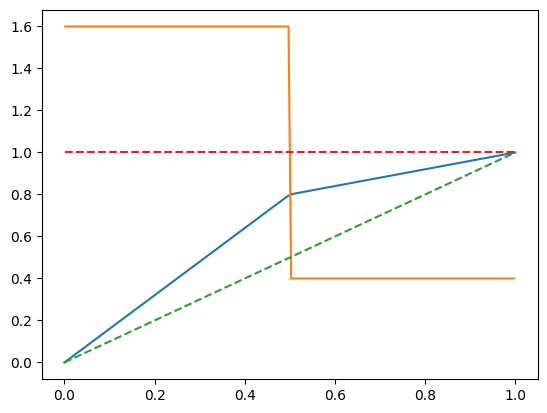

In [49]:
def getu_target(x):
    k1 = 1
    k2 = 4
    c1 = 2./(1.+k1/k2)
    c2 = -2.*k1/(k1+k2)
    ul = c1*x
    ur = 1.+c2*(1.-x)
    signPlus = (x > 0.5).astype(np.float64)
    signNeg = (x <= 0.5).astype(np.float64)
    return ur*signPlus + ul*signNeg

def getdudx_target(x):
    k1 = 1
    k2 = 4
    c1 = 2./(1.+k1/k2)
    c2 = -2.*k1/(k1+k2)
    dxul = c1
    dxur = -c2
    signPlus = (x > 0.5).astype(np.float64)
    signNeg = (x <= 0.5).astype(np.float64)
    return dxur*signPlus + dxul*signNeg

def kappa_target(x):
    k1 = 1
    k2 = 4
    signPlus = (x > 0.5).astype(np.float64)
    signNeg = (x <= 0.5).astype(np.float64)
    return k1*signPlus + k2*signNeg

ut_nodes = np.expand_dims(getu_target(points),-1)
dudxt_nodes = np.expand_dims(getdudx_target(xq),-1)
plt.plot(points,ut_nodes)
plt.plot(xq,dudxt_nodes)
data_dict = {u_target:ut_nodes,dudx_target:dudxt_nodes}
plt.plot(points,sess.run(u_sol),'--')
plt.plot(xq,sess.run(dx_sol),'--')

In [50]:
for cnt in range(2000):
  if cnt%200==0:
    print(cnt, 'LOSS ',sess.run(LOSS_total,feed_dict=data_dict))
    print('   sol error '+str(np.mean(np.abs(sess.run(u_sol) - ut_nodes)**2)))
    print('   grad error '+str(np.mean(np.abs(sess.run(tf.expand_dims(dx_sol,-1))-dudxt_nodes)**2)))
  sess.run(optimizer_step,feed_dict=data_dict)

0 LOSS  71.28000000001985
   sol error 0.029696969697005287
   grad error 0.36000000000010035
200 LOSS  34.89508578774133
   sol error 0.014382106267971017
   grad error 0.17623780700879463
400 LOSS  16.293881831557865
   sol error 0.0065460990217008
   grad error 0.08229233248261549
600 LOSS  7.657459739234108
   sol error 0.002901069106858591
   grad error 0.03867403908704095
800 LOSS  3.7791250607211966
   sol error 0.001262695548550121
   grad error 0.019086490205662606
1000 LOSS  2.051033276646227
   sol error 0.0005363376814557013
   grad error 0.010358753922455693
1200 LOSS  1.2855839168597738
   sol error 0.00021932073224352393
   grad error 0.006492848064948352
1400 LOSS  0.9531223694456353
   sol error 8.480278786342351e-05
   grad error 0.004813749340634522
1600 LOSS  0.8144030217954815
   sol error 3.035140147874136e-05
   grad error 0.004113146574724654
1800 LOSS  0.7597064084777135
   sol error 9.819797489336226e-06
   grad error 0.0038369010529177468


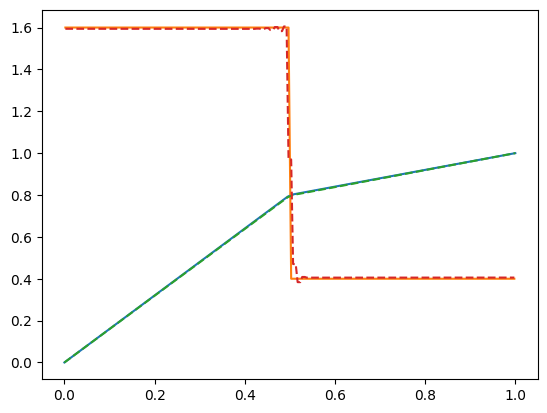

In [51]:
plt.plot(points,ut_nodes)
plt.plot(xq,dudxt_nodes)
data_dict = {u_target:ut_nodes,dudx_target:dudxt_nodes}
plt.plot(points,sess.run(u_sol),'--')
plt.plot(xq,sess.run(dx_sol),'--')

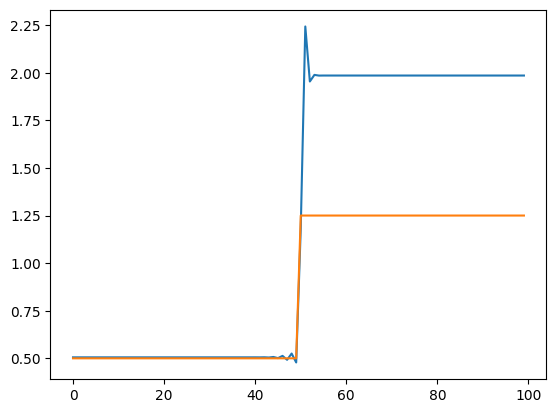

In [54]:
plt.plot(sess.run(kappa_nodal))
plt.plot(1./kappa_target(points)+.25)